In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os
import shutil
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import teotil3 as teo

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


# TEOTIL3 Trondheimsfjorden

# Part 6a: Generate model input files for "large" wastewater scenarios

Assume all sites serving more than 10k people are upgraded to `Biologisk/kjemisk med N fjerning`. Assume treatment efficiencies broadly in line with the Wastewater Treatment Directive (80% for TOTN, 90% for TOTP, 75% for BOF5, 75% for KOF; see e-mail from Christian V received 11.11.2024).

**Note:** In both TEOTIL3 and SSB's worklflow, linear relationships are assumed to convert between BOF5 and KOF. These relationships are used to fill gaps in the reporting (see e.g. Tabell 2.6 in the SSB report [here](https://www.ssb.no/natur-og-miljo/vann-og-avlop/artikler/kommunale-avlop-2022.ressursinnsats-gebyrer-utslipp-rensing-og-slamdisp/_/attachment/inline/55f4defd-3ce9-4971-a61e-5aa0b19ada33:c2bb61b653fbd48d67930abcbb3c9e29f6bc1ccf/RAPP2023-50.pdf)). NIBIO produce removal efficiencies for BOF5, but not KOF. However, for TEOTIL, I also need efficiencies for KOF. Because of the assumption that BOF5 is a fixed fraction of KOF, it makes sense to use the same efficiencies for both i.e. $E_{KOF} = E_{BOF5}$. In reality this may not be accurate, because different treatment methods may preferentially target organic matter fractions that are more (or less) bioavailable. In Christian's e-mail, the BOF5 target for the WWD is 75-90% and for KOF it's 75%. Using 75% for both therefore seems consistent.

In [4]:
nve_year = 2024
st_yr, end_yr = 2013, 2023
orig_teo3_input_fold = r"/home/jovyan/shared/common/teotil3/trondheimsfjorden_scenarios/teotil3_input_files/Baseline"
scen_name = "AV1"

# See e-mail from Christian received 11.11.2024
totn_removal_eff_pct = 80
totp_removal_eff_pct = 90
# bof5_removal_eff_pct = 75
# kof_removal_eff_pct = 75

# EITHER: Upgrade sites with capacity (i.e. number of people)
# greater than this value. Int or None
cap_thresh = 10000

# OR: Upgrade list of specific sites. List or None
upgrade_site_list = None

# Whether to delete the scenario folder first if it already exists
delete_existing = True

if cap_thresh and upgrade_site_list:
    raise ValueError("Specify either 'cap_thresh' or 'upgrade_site_list', not both.")

In [5]:
# Create scenario folder structure
scen_data_fold = f"/home/jovyan/shared/common/teotil3/trondheimsfjorden_scenarios/teotil3_input_files/{scen_name}"
if os.path.exists(scen_data_fold) and delete_existing:
    shutil.rmtree(scen_data_fold)
os.makedirs(scen_data_fold)

# Generate modified point data for scenario
print("Generating scenario data")
years = range(st_yr, end_yr + 1)
for year in years:
    print("    ", year)

    # Copy original data to scenario folder
    src_data_fold = f"/home/jovyan/shared/common/teotil3/point_data/{year}"
    scen_ann_data_fold = os.path.join(scen_data_fold, str(year))
    shutil.copytree(src_data_fold, scen_ann_data_fold)

    # Read site types
    type_xlsx = os.path.join(
        scen_ann_data_fold, f"avlop_stor_anlegg_{year}_treatment_types_bof_kof.xlsx"
    )
    type_df = pd.read_excel(type_xlsx, sheet_name="data")

    if cap_thresh:
        # Get sites IDs for plants bigger than 'cap_thresh'
        cap_list = list(type_df.query("KAPASITET1 > @cap_thresh")["ANLEGGSNR"].unique())
    else:
        # User-specified site list
        cap_list = upgrade_site_list

    # Upgrade these sites to 'Kjemisk-biologisk m/N-fjerning'
    type_df.loc[type_df["ANLEGGSNR"].isin(cap_list), "RENSPRINS"] = (
        "Kjemisk-biologisk m/N-fjerning"
    )
    type_df.to_excel(type_xlsx, sheet_name="data")

    # Read discharge data
    stan_xlsx = os.path.join(scen_ann_data_fold, f"avlop_stor_anlegg_{year}_raw.xlsx")
    stan_df = pd.read_excel(stan_xlsx, sheet_name=f"store_anlegg_{year}")

    # Upgrade renseeffekt for sites bigger than 'cap_thresh'
    stan_df.loc[stan_df["ANLEGGSNR"].isin(cap_list), "RENSEEFFEKT_P"] = (
        totp_removal_eff_pct / 100
    )
    stan_df.loc[stan_df["ANLEGGSNR"].isin(cap_list), "RENSEEFFEKT_N"] = (
        totn_removal_eff_pct / 100
    )
    # stan_df.loc[stan_df["ANLEGGSNR"].isin(cap_list), "RENSEEFFEKT_BOF5"] = (
    #     bof5_removal_eff_pct / 100
    # )
    # stan_df.loc[stan_df["ANLEGGSNR"].isin(cap_list), "RENSEEFFEKT_KOF"] = (
    #     kof_removal_eff_pct / 100
    # )

    # Recalculate discharges
    stan_df["MENGDE_N_UT_kg"] = stan_df["MENGDE_N_INN_kg"] * (
        1 - stan_df["RENSEEFFEKT_N"]
    )
    stan_df["MENGDE_P_UT_kg"] = stan_df["MENGDE_P_INN_kg"] * (
        1 - stan_df["RENSEEFFEKT_P"]
    )
    # stan_df["MENGDE_BOF5_UT_kg"] = stan_df["MENGDE_BOF5_INN_kg"] * (
    #     1 - stan_df["RENSEEFFEKT_BOF5"]
    # )
    # stan_df["MENGDE_KOF_UT_kg"] = stan_df["MENGDE_KOF_INN_kg"] * (
    #     1 - stan_df["RENSEEFFEKT_KOF"]
    # )

    stan_df.to_excel(stan_xlsx, sheet_name=f"store_anlegg_{year}")

Generating scenario data
     2013
     2014
     2015
     2016
     2017
     2018
     2019
     2020
     2021
     2022
     2023


## 2. Modify TEOTIL3 input files

In [6]:
%%capture

# Read supporting tables from db
reg_gdf = teo.io.get_regine_geodataframe(eng, 2022)
par_df = pd.read_sql("SELECT * FROM teotil3.output_param_definitions", eng)
conv_df = pd.read_sql("SELECT * FROM teotil3.input_output_param_conversion", eng)

par_list = [
    "totn_kg",
    "din_kg",
    "ton_kg",
    "totp_kg",
    "tdp_kg",
    "tpp_kg",
    "toc_kg",
    "ss_kg",
]

print("Patching model input files")
for year in years:
    print("    ", year)

    # Read scenario data for large wastewater
    scen_ann_data_fold = os.path.join(scen_data_fold, str(year))
    loc_gdf, df = teo.preprocessing.read_large_wastewater_and_industry_data(
        scen_ann_data_fold, year, eng
    )

    # Assign to regines
    loc_df = gpd.sjoin(
        loc_gdf,
        reg_gdf[["regine", "geometry"]],
        how="inner",
        predicate="within",
    )[["site_id", "sector", "regine"]]

    # Convert units and aggregate
    df = pd.merge(df, conv_df, how="left", on="in_par_id")
    df = pd.merge(df, par_df, how="left", on="out_par_id")
    df = pd.merge(df, loc_df, how="left", on="site_id")

    df = df.query("sector == 'Large wastewater'")

    df["name"] = df["name"] + "_" + df["unit"]
    df["value"] = df["value"] * df["factor"]
    df = (
        df[["regine", "name", "value"]]
        .groupby(["regine", "name"])
        .sum()
        .reset_index()
        .pivot(index="regine", columns="name", values="value")
    )
    cols = [f"large-wastewater_{col.lower()}" for col in df.columns]
    df.columns = cols
    df.columns.name = ""
    cols = [
        f"large-wastewater_{col}"
        for col in par_list
        if f"large-wastewater_{col}" in df.columns
    ]
    df = df[cols].copy()
    df = df.round(1)
    df.reset_index(inplace=True)

    # Read original TEOTIL3 input files
    in_csv = os.path.join(
        orig_teo3_input_fold,
        f"trondheimsfjorden_input_data_scen-baseline_nve{nve_year}_{year}.csv",
    )
    in_df = pd.read_csv(in_csv)

    # Patch input for large ww with scenario values
    drop_cols = [col for col in df.columns if col != "regine"]
    in_df.drop(columns=drop_cols, inplace=True)
    in_df = pd.merge(in_df, df, how="left", on="regine")
    for col in drop_cols:
        in_df[col] = in_df[col].fillna(0)

    # Save modified model input file
    scen_csv = os.path.join(
        scen_data_fold,
        f"trondheimsfjorden_input_data_scen-{scen_name.lower()}_nve{nve_year}_{year}.csv",
    )
    in_df.to_csv(scen_csv, index=False)
    shutil.rmtree(scen_ann_data_fold)

## 3. Compare input files

In [7]:
for year in years:
    orig_csv = os.path.join(
        orig_teo3_input_fold,
        f"trondheimsfjorden_input_data_scen-baseline_nve{nve_year}_{year}.csv",
    )
    orig_df = pd.read_csv(orig_csv)

    scen_csv = os.path.join(
        scen_data_fold,
        f"trondheimsfjorden_input_data_scen-{scen_name.lower()}_nve{nve_year}_{year}.csv",
    )
    scen_df = pd.read_csv(scen_csv)

    assert scen_df.shape == orig_df.shape

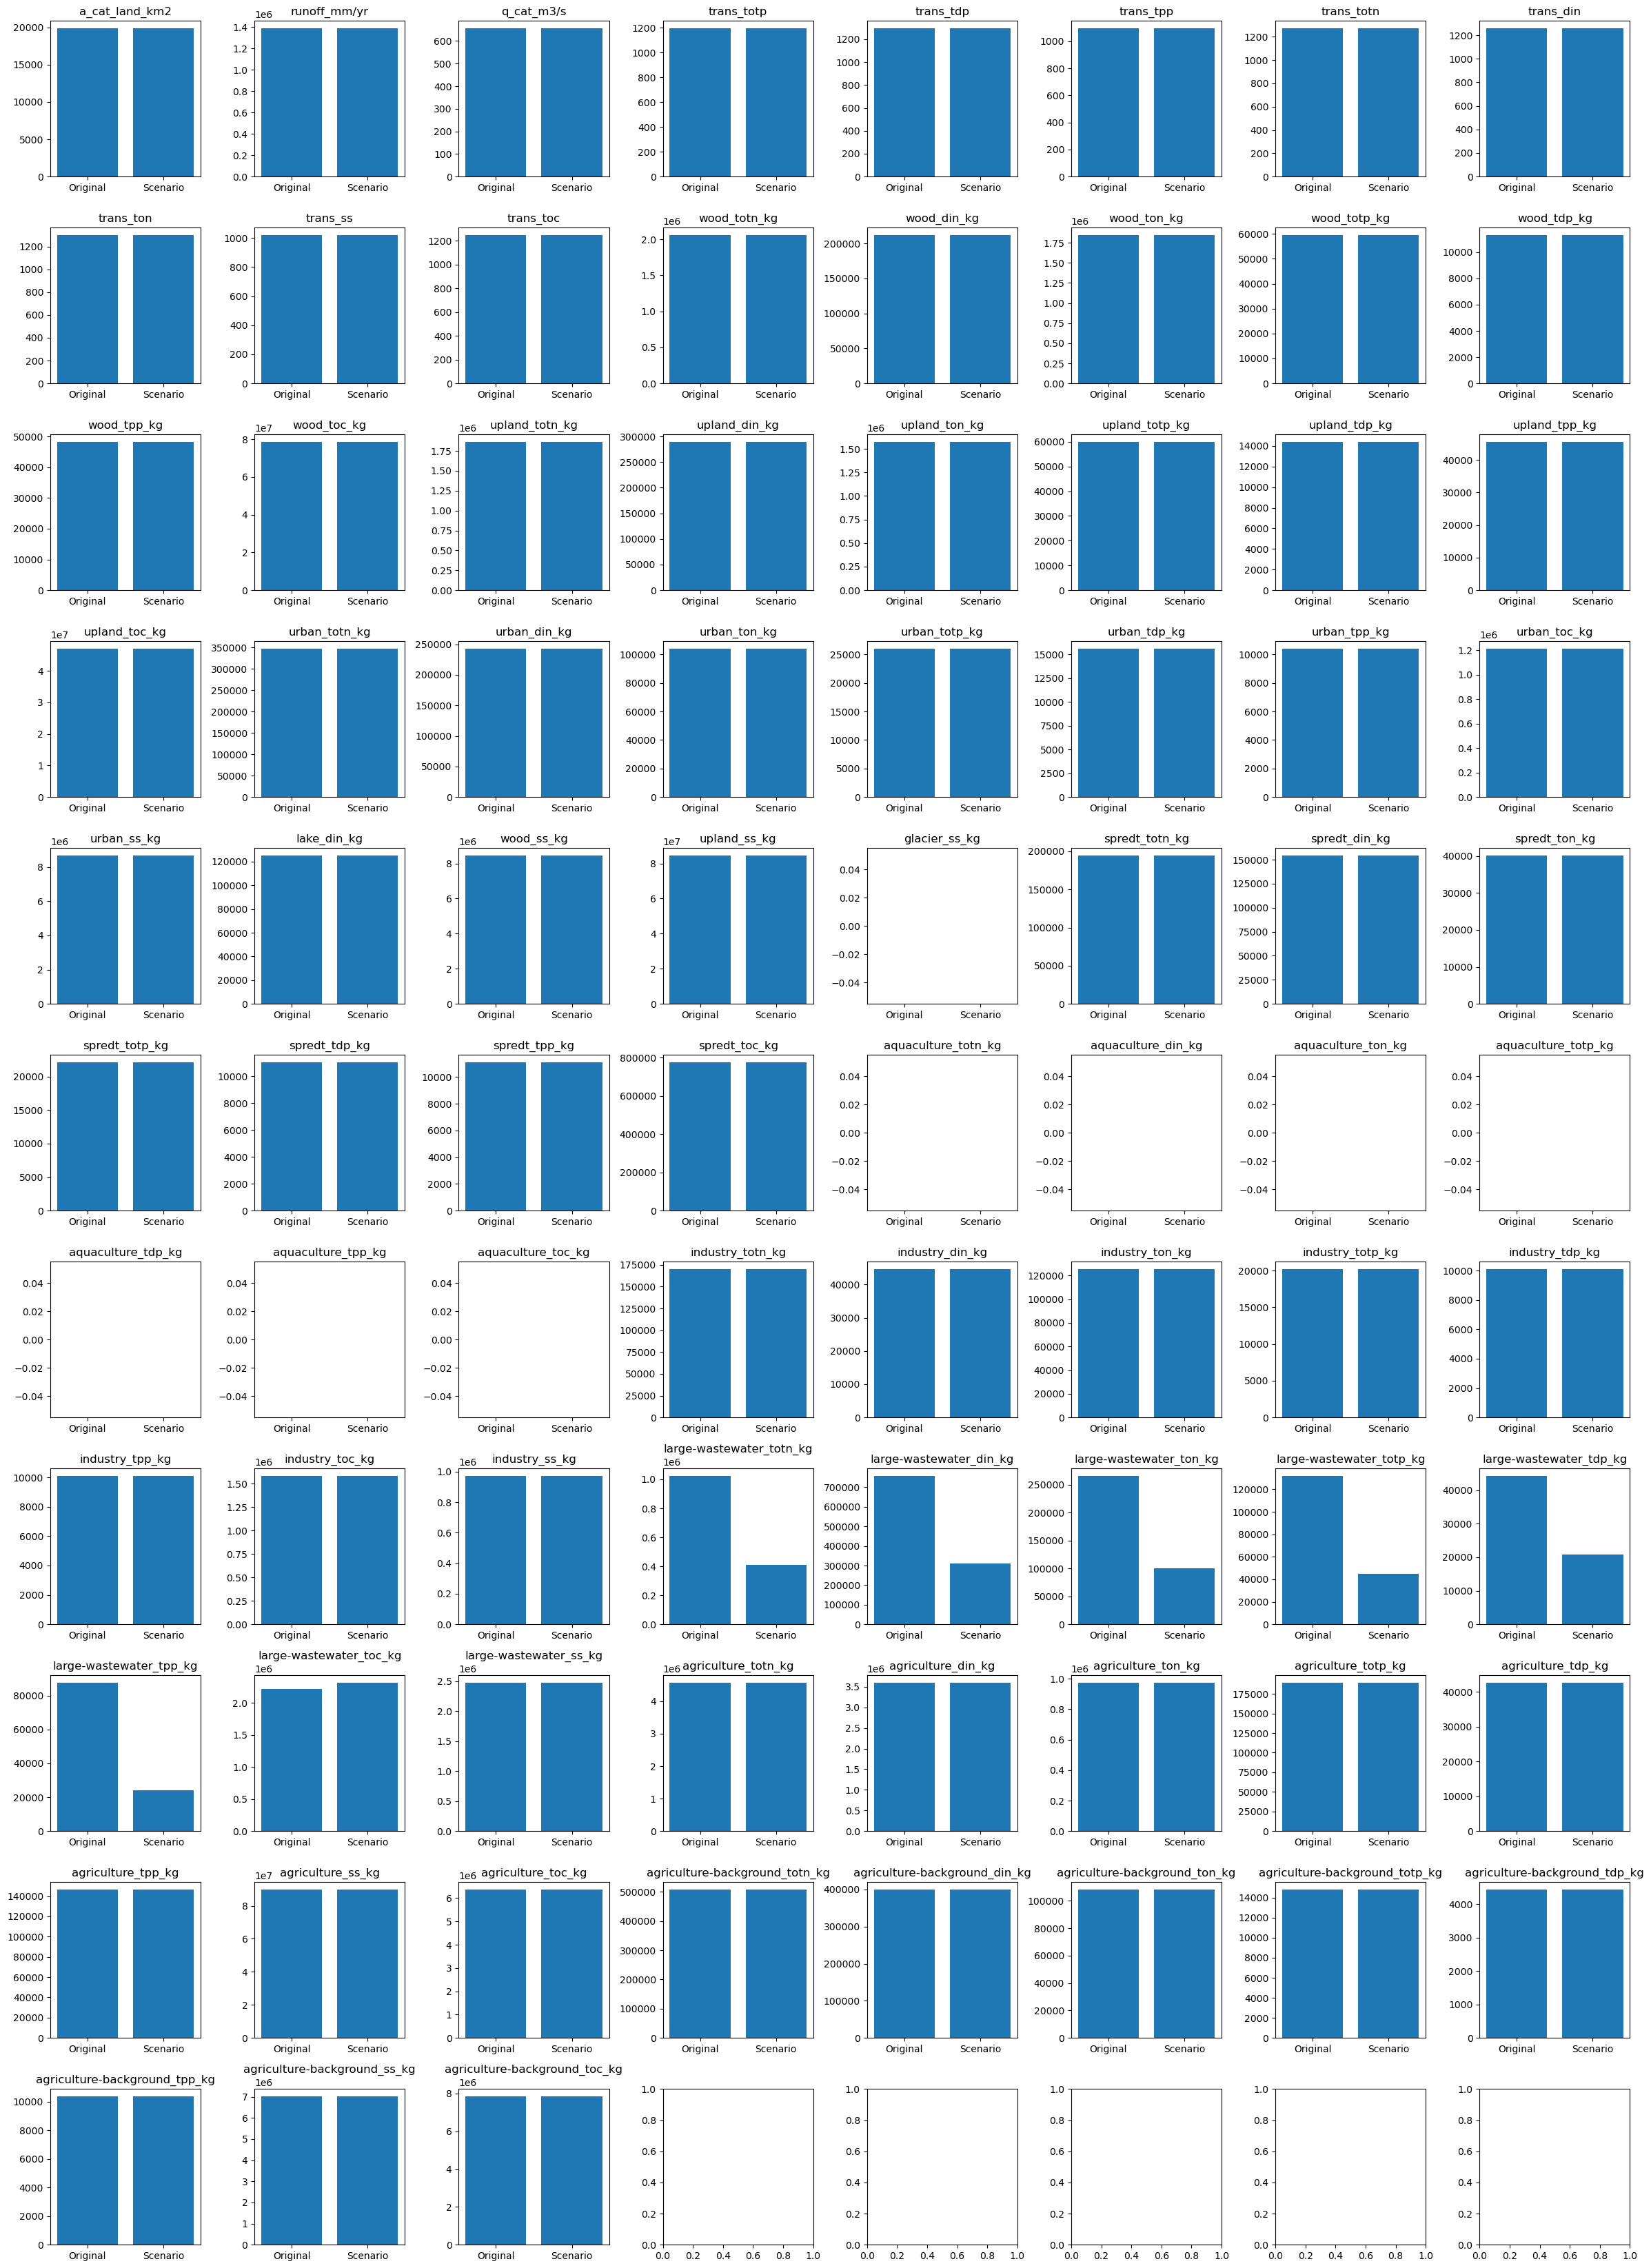

In [8]:
# Plot national total for each model input by source for the last year
# Just to check that only large wastewater has changed.
n_subplots = len(orig_df.select_dtypes(include="number").columns)
n_cols = 8
fig, axes = plt.subplots(
    int(n_subplots / n_cols) + 1,
    n_cols,
    figsize=(n_cols * 3, (int(n_subplots / n_cols) + 1) * 3),
)
axes = axes.flatten()
for i, col in enumerate(orig_df.select_dtypes(include="number").columns):
    axes[i].bar(["Original", "Scenario"], [orig_df.sum()[col], scen_df.sum()[col]])
    axes[i].set_title(col)

plt.tight_layout()